In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import datetime
from itertools import product

In [2]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016

In [3]:
nielsen = pd.concat((nielsen15, nielsen16))
nielsen = nielsen[~nielsen.is_walmart]

In [4]:
## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stillremain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
nielsen = nielsen[~np.isin(nielsen.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
#movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
# Correction des effets de bord M12
movements = fandom[((fandom.Opening_date >= '2014-01-31') & (fandom.Opening_date <= '2018-01-31')) | ((fandom.Closing_date >= '2014-01-31') & (fandom.Closing_date <= '2018-01-31'))]

In [10]:
hey = nielsen.groupby('product_group_descr').count()
categories = hey[hey.is_walmart>=25000].index

Size of the control group: 1802.
Size of the treatment group: 65.


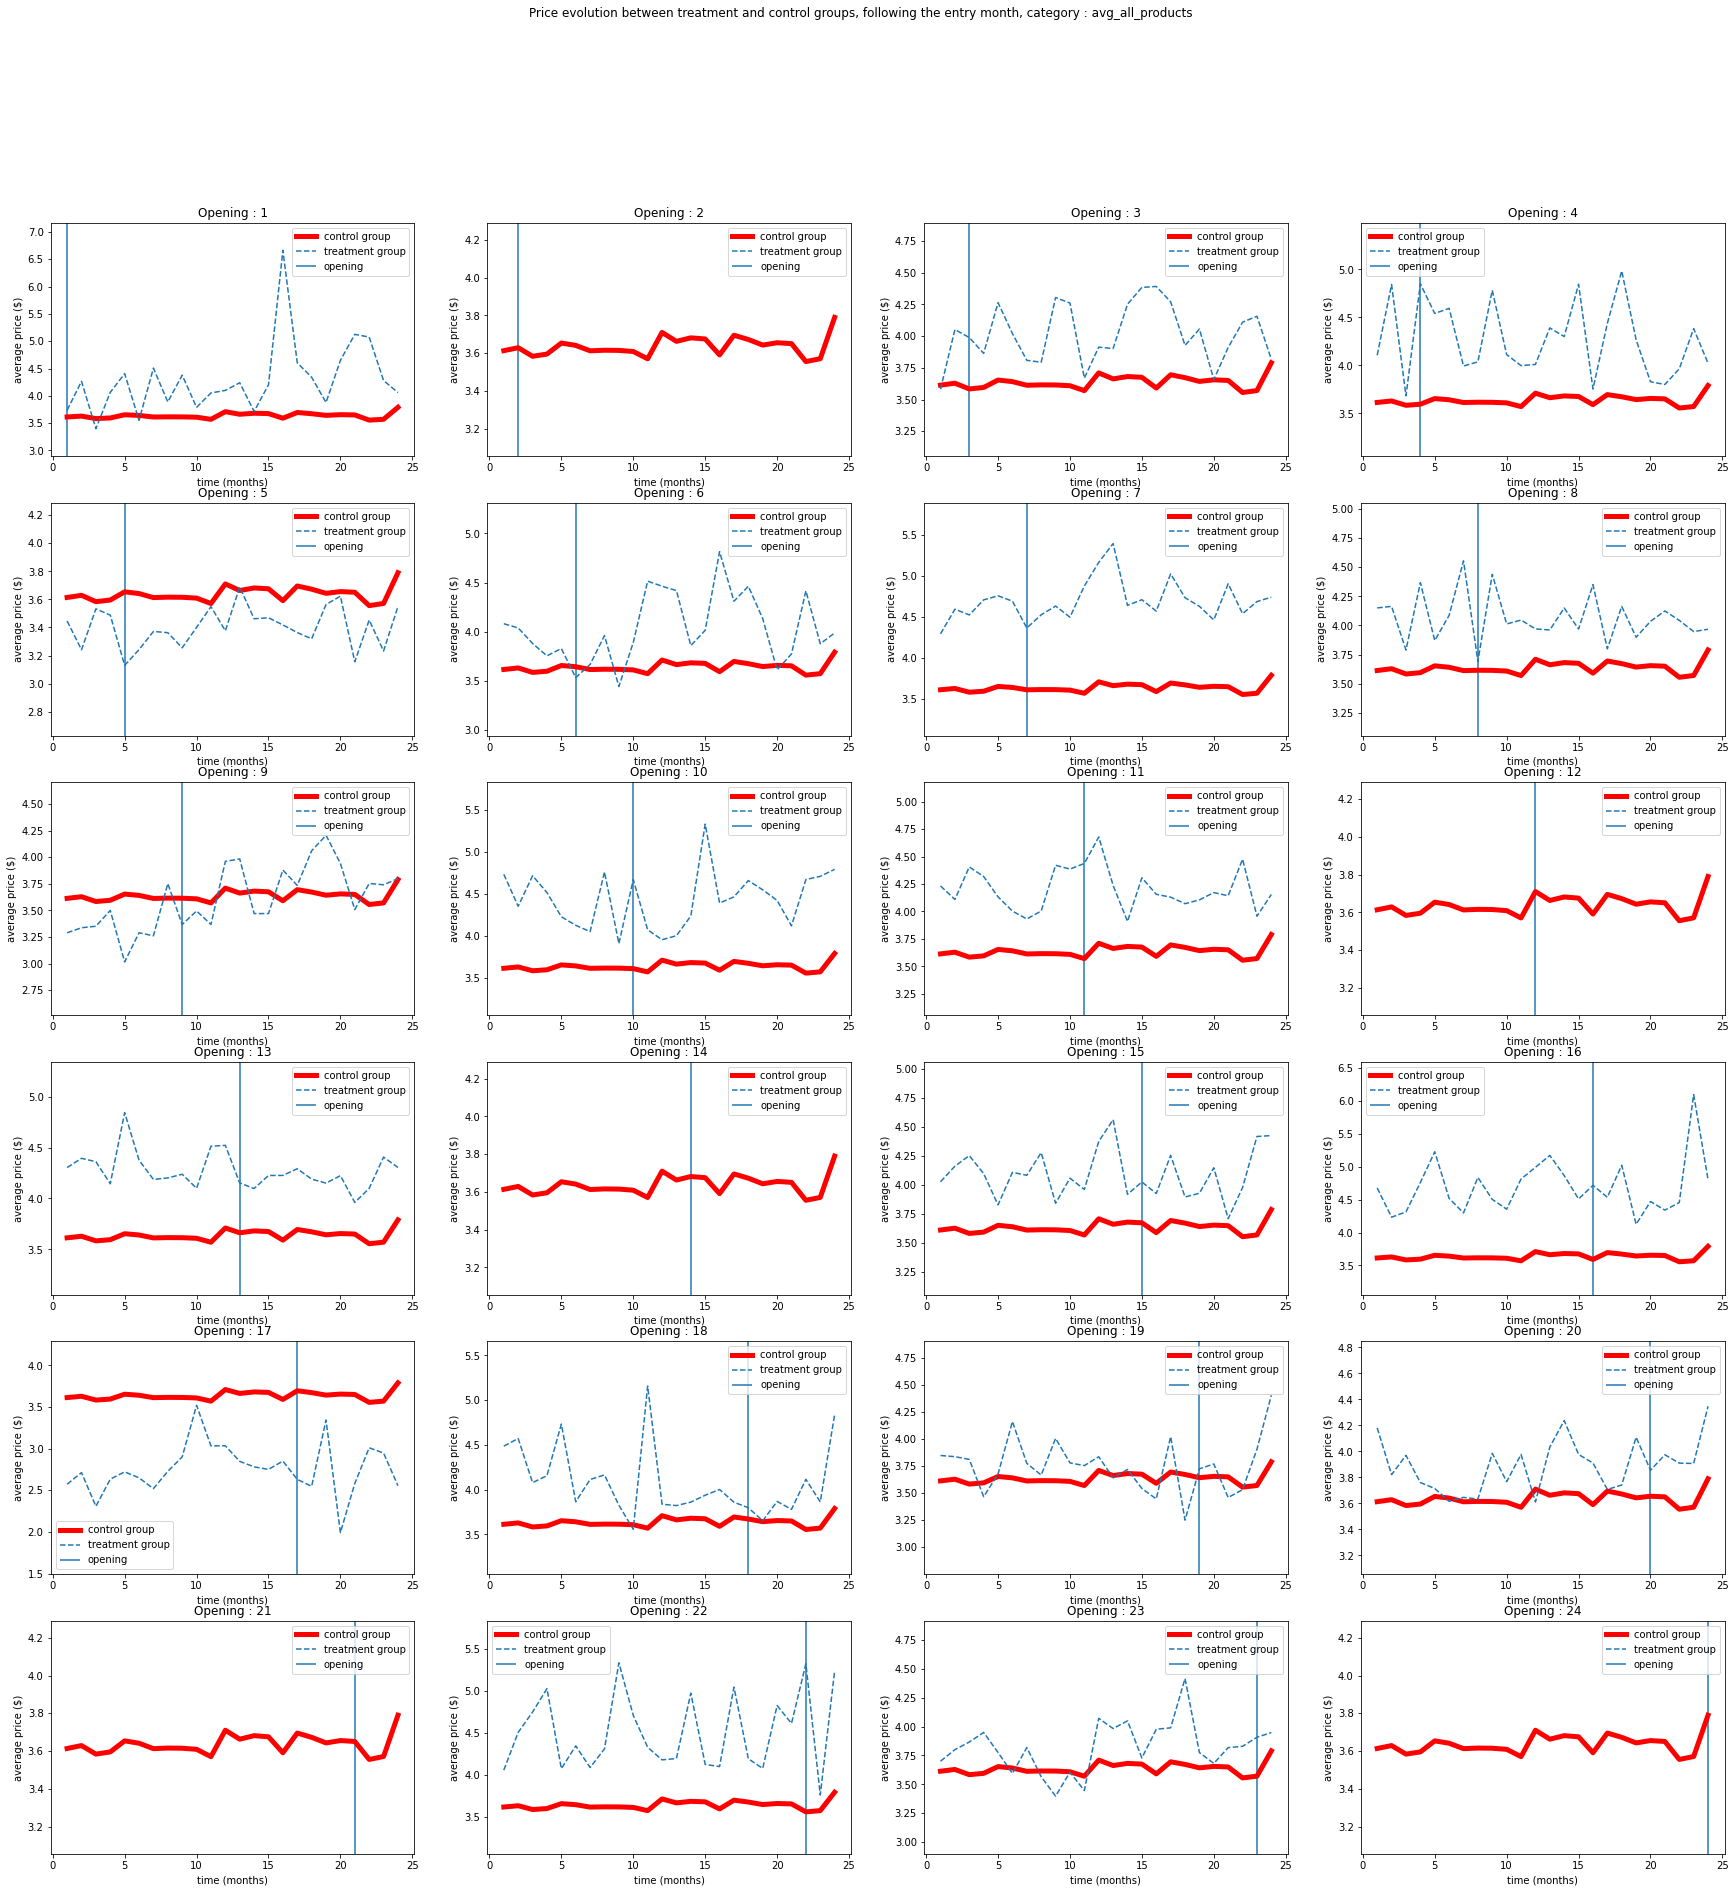

In [5]:
# We choose to focus on milk prices
for category in ['avg_all_products']:
    #product_group = nielsen[nielsen.product_group_descr == category]
    product_group = pd.DataFrame(nielsen.groupby(['is_walmart', 'store_state', 'guessed_store_county', 'guessed_store_county_fips', 'purchase_year', 'purchase_month']).mean()['upc_price']).reset_index()


    # The control group is composed by all states where nothing (no entry nor exit) happened.
    control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()
    print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


    # The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
    count = movements.groupby('County_fips').count()
    count = count[count.State == 1] # No more than one movement in the treatement group
    treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
    treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]

    treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
    treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
    print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


    # We create our dummies for the regression
    control['treat'] = False
    control['purchase_0'] = control.purchase_month + 12 * (control.purchase_year - 2015)
    control['interaction'] = False

    treatment['treat'] = True
    #treatment['interaction'] = ((treatment.Opening_date.dt.year == treatment.purchase_year) & (treatment.Opening_date.dt.month > treatment.purchase_month)) | (treatment.purchase_year > treatment.Opening_date.dt.year)
    treatment['purchase_0'] = treatment.purchase_month + 12 * (treatment.purchase_year - 2015)
    treatment['opening_0'] = treatment.Opening_date.dt.month  + 12 * (treatment.Opening_date.dt.year - 2015)

    control_plot = control.groupby(['purchase_0']).mean('upc_price')['upc_price']
    treatment_plot = treatment.groupby(['opening_0', 'purchase_0']).mean('upc_price')['upc_price'].reset_index()

    fig, ax = plt.subplots(6, 4, figsize=(30, 30))

    month = 0

    plt.suptitle(f"Price evolution between treatment and control groups, following the entry month, category : {category}")

    for i, j in product(range(6), range(4)):
        month +=1
        ax[i][j].plot(control_plot.index, control_plot, color='red', linewidth =5, label='control group')
        ax[i][j].plot(treatment_plot[treatment_plot.opening_0 == month].purchase_0, treatment_plot[treatment_plot.opening_0 == month].upc_price, linestyle ='--', label='treatment group')
        a = max(control_plot.max(), treatment_plot[treatment_plot.opening_0 == month].upc_price.max() ) + 0.5
        b = min(control_plot.min(), treatment_plot[treatment_plot.opening_0 == month].upc_price.min() ) - 0.5
        ax[i][j].vlines(month, b, a, label='opening')
        ax[i][j].set_ylim((b, a))
        ax[i][j].set_xlabel('time (months)')
        ax[i][j].set_ylabel('average price ($)')
        ax[i][j].set_title(f'Opening : {month}')
        ax[i][j].legend()
    
    fig.savefig(f"./figs/parallel_{category.replace('/', '_')}", facecolor='white')


Size of the control group: 0.
Size of the treatment group: 0.


/opt/miniconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


ValueError: Axis limits cannot be NaN or Inf

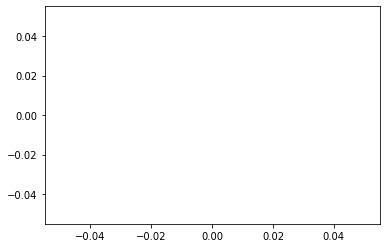

In [9]:
# We choose to focus on milk prices
for category in ['UNPREPARED MEAT/POULTRY/SEAFOOD-FRZN']:
    product_group = nielsen[nielsen.product_group_descr == category]
    #product_group = pd.DataFrame(nielsen.groupby(['is_walmart', 'store_state', 'guessed_store_county', 'guessed_store_county_fips', 'purchase_year', 'purchase_month']).mean()['upc_price']).reset_index()


    # The control group is composed by all states where nothing (no entry nor exit) happened.
    control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()

    # Keeping in the control group the only counties where we have data for the entire time period (24 months)
    nb_months = control.groupby('guessed_store_county_fips').count()
    control = control[np.isin(control.guessed_store_county_fips, nb_months[nb_months.is_walmart==24].index)]

    # Keeping in the control group the only counties where 4 observations per month and category at least
    nb_obs = control.groupby('guessed_store_county_fips').min()
    control = control[np.isin(control.guessed_store_county_fips, nb_obs[nb_obs.nb_of_obs > 3].index)]
    print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


    # The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
    count = movements.groupby('County_fips').count()
    count = count[count.State == 1] # No more than one movement in the treatement group
    treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
    treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]

    treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
    treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
    print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


    # We create our dummies for the regression
    control['treat'] = False
    control['purchase_0'] = control.purchase_month + 12 * (control.purchase_year - 2015)
    control['interaction'] = False

    treatment['treat'] = True
    #treatment['interaction'] = ((treatment.Opening_date.dt.year == treatment.purchase_year) & (treatment.Opening_date.dt.month > treatment.purchase_month)) | (treatment.purchase_year > treatment.Opening_date.dt.year)
    treatment['purchase_0'] = treatment.purchase_month + 12 * (treatment.purchase_year - 2015)
    treatment['opening_0'] = treatment.Opening_date.dt.month  + 12 * (treatment.Opening_date.dt.year - 2015)

    control_plot = control.groupby(['purchase_0']).mean('upc_price')['upc_price']
    treatment_plot = treatment.groupby(['opening_0', 'purchase_0']).mean('upc_price')['upc_price'].reset_index()

    month = 15

    #fig, ax = plt.subplots(6, 4, figsize=(30, 30))
    """
    month = 0

    plt.suptitle(f"Price evolution between treatment and control groups, following the entry month, category : {category}")

    for i, j in product(range(6), range(4)):
        month +=1
        ax[i][j].plot(control_plot.index, control_plot, color='red', linewidth =5, label='control group')
        ax[i][j].plot(treatment_plot[treatment_plot.opening_0 == month].purchase_0, treatment_plot[treatment_plot.opening_0 == month].upc_price, linestyle ='--', label='treatment group')
        a = max(control_plot.max(), treatment_plot[treatment_plot.opening_0 == month].upc_price.max() ) + 0.5
        b = min(control_plot.min(), treatment_plot[treatment_plot.opening_0 == month].upc_price.min() ) - 0.5
        ax[i][j].vlines(month, b, a, label='opening')
        ax[i][j].set_ylim((b, a))
        ax[i][j].set_xlabel('time (months)')
        ax[i][j].set_ylabel('average price ($)')
        ax[i][j].set_title(f'Opening : {month}')
        ax[i][j].legend()
    
    fig.savefig(f"./figs/parallel_{category.replace('/', '_')}", facecolor='white')"""

    plt.plot(control_plot.index, control_plot, color='red', linewidth =3, label='control group')
    plt.plot(treatment_plot[treatment_plot.opening_0 == month].purchase_0, treatment_plot[treatment_plot.opening_0 == month].upc_price, linestyle ='--', label='treatment group')
    a = max(control_plot.max(), treatment_plot[treatment_plot.opening_0 == month].upc_price.max() ) + 0.5
    b = min(control_plot.min(), treatment_plot[treatment_plot.opening_0 == month].upc_price.min() ) - 0.5
    plt.vlines(month, b, a, label='opening')
    plt.ylim((b, a))
    plt.xlabel('time (months)')
    plt.ylabel('average price ($)')
    plt.title(f'Parallel trends - Candy - Opening in Jan. 2016')
    plt.legend()

    #plt.savefig(f'../presentation/figs/parralel_candy.png', facecolor='white')

